In [1]:
# Jupyter Cell 1  – imports & basic objects
%cd ../..
%pwd

from pathlib import Path
import torch, joblib, numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

MODEL_PATH = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
PROBE_PATH = Path("linear_probes/realyesno_NoneQ/linear_probe_layer14.joblib")

device     = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_PATH, padding_side="left")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True
).to(device).eval()

probe       = joblib.load(PROBE_PATH)
w_probe     = torch.from_numpy(probe.coef_[0]).to(device).float()   # **raw weight**
intercept   = float(probe.intercept_[0])
best_layer  = len(model.model.layers) - 1

print("probe ‖w‖ =", w_probe.norm().item(), "  intercept =", intercept)


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 41.42it/s]


probe ‖w‖ = 5.613587856292725   intercept = 0.07921282947063446


In [2]:
# ★ NEW Cell 2  -----------------------------------------------------------
# 1. YES–NO logit direction from lm_head
# replace both occurrences
id_yes = tokenizer.encode(" YES", add_special_tokens=False)[0]   # leading␠space
id_no  = tokenizer.encode(" NO",  add_special_tokens=False)[0]

W      = model.lm_head.weight.data.to(torch.float32)      # (vocab, H)
w_lm   = (W[id_yes] - W[id_no]).to(device)                # YES minus NO
w_lm_norm_sq = w_lm.pow(2).sum()

print("‖w_lm‖ =", w_lm.norm().item())

# 2. hook factory – shift the YES–NO logit gap by β logit-units
def make_steer_hook(beta_logit: float):
    """
    Δh = (beta_logit / ‖w_lm‖²) · w_lm   ⇒   logitYES−logitNO += beta_logit
    """
    delta = (beta_logit / w_lm_norm_sq) * w_lm          # (H,)

    def _hook(mod, inp, out):
        h = out[0] if isinstance(out, tuple) else out   # (B,seq,H)
        h[:, -1, :] += delta.to(h.dtype)                # nudge last token
        if isinstance(out, tuple):
            return (h,) + out[1:]
        return h
    return _hook

# neutral hook
handle = model.model.layers[best_layer].register_forward_hook(
    make_steer_hook(beta_logit=0.0)
)
print(f"Hook registered on layer {best_layer}")


‖w_lm‖ = 0.9835094213485718
Hook registered on layer 31


In [3]:
# Jupyter Cell 3 – single-step generation helper

answer_tokens = {
    "YES": id_yes,
    "NO" : id_no,
}


def model_yes_no(prompts, max_new_tokens=1):
    enc = tokenizer(prompts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            return_dict_in_generate=True,
        )
    first = out.sequences[:, enc.input_ids.size(1)]
    return ["YES" if t.item() == answer_tokens["YES"] else "NO" for t in first]


In [4]:
# Jupyter Cell 4 — build 64 YES + 64 NO prompts
import json, random, itertools
from pathlib import Path

root = Path("data/chainscope/questions_json/linked")
yes_files = list((root/"gt_YES_1").glob("*.json"))[:2]
no_files  = list((root/"gt_NO_1" ).glob("*.json"))[:2]

def load_prompts(flist, answer):
    out = []
    for fp in flist:
        with open(fp) as f:
            qs = json.load(f)["questions"]
        for q in qs:
            out.append((q["q_str"], answer))
    return out

batch = load_prompts(yes_files, "YES") + load_prompts(no_files, "NO")
random.shuffle(batch)
prompts, ground_truth = zip(*batch[:128])   # 64 YES + 64 NO
print("balanced sample size =", len(prompts),
      "| YES:", ground_truth.count("YES"),
      "| NO :", ground_truth.count("NO"))


balanced sample size = 128 | YES: 63 | NO : 65


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Δlogit=-2.0  acc=0.508
Δlogit=-1.5  acc=0.508


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Δlogit=-1.0  acc=0.508
Δlogit=-0.5  acc=0.508


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Δlogit=+0.0  acc=0.508
Δlogit=+0.5  acc=0.508


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Δlogit=+1.0  acc=0.508
Δlogit=+1.5  acc=0.508
Δlogit=+2.0  acc=0.508


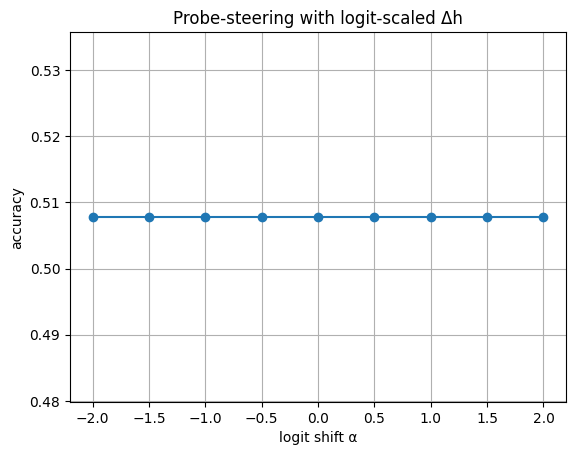

In [5]:
def accuracy(preds, refs):
    return sum(p == r for p, r in zip(preds, refs)) / len(refs)
    

alphas = np.linspace(-2, 2,  nine := 9)   # try negative and positive pushes
accs   = []

for a in alphas:
    handle.remove()
    handle = model.model.layers[best_layer].register_forward_hook(
        make_steer_hook(beta_logit=a)
    )
    accs.append(accuracy(model_yes_no(prompts), ground_truth))
    print(f"Δlogit={a:+.1f}  acc={accs[-1]:.3f}")

plt.plot(alphas, accs, marker="o"); plt.grid(True)
plt.xlabel("logit shift α"); plt.ylabel("accuracy")
plt.title("Probe-steering with logit-scaled Δh")
plt.show()


In [8]:
handle.remove()
handle = model.model.layers[best_layer].register_forward_hook(
    make_steer_hook(beta_logit=+2.0)
)
print(model_yes_no(["Is 2+2 equal to 5?"]))   # expect " NO"
handle.remove()
print(model_yes_no(["Is 2+2 equal to 5?"]))   # should be back to baseline


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['NO']
['NO']


In [6]:
# Jupyter Cell 6 – spot-check which questions flip

alpha = 2.0
handle.remove()
handle = model.model.layers[best_layer].register_forward_hook(make_steer_hook(alpha))

preds_steer = model_yes_no(prompts)
handle.remove()                                         # disable steering
preds_base  = model_yes_no(prompts)

for i,(pB,pS,gt) in enumerate(zip(preds_base, preds_steer, ground_truth)):
    if pB != pS:
        print(f"{i:3d} | GT={gt} | base={pB} -> steer={pS}")
        print(prompts[i].splitlines()[-1][:120], "…")
        print("-"*60)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [7]:
hidden = torch.load("h_hidden_space/???.pt")[best_layer]  # (B,H)
logits = (hidden @ probe.coef_[0] + probe.intercept_[0]).cpu().numpy()
pred   = (logits > 0)   # 1 = “correct”, 0 = “wrong & same”


/tmp/ipykernel_44898/100140189.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hidden = torch.load("h_hidden_space/???.pt")[best_layer]  # (B,H)


FileNotFoundError: [Errno 2] No such file or directory: 'h_hidden_space/???.pt'